# **Libraries**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

# **Loading Data**

In [3]:
# Set up data loading
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure all images are 32x32
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:11<00:00, 15437039.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **Auxiliary Functions**

In [49]:
# Visualization functions
def visualize_feature_maps(feature_maps, title, root):
    num_maps = min(16, feature_maps.size(1))
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(num_maps):
        ax = axes[i // 4, i % 4]
        ax.imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    plt.savefig(root)
    
def visualize_image(image, title, root):
    plt.figure(figsize=(8, 8))
    plt.imshow(image.permute(1,2,0))
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.savefig(root)


def visualize_attention_map(attention_weights, title, root):
    att_map = attention_weights[0].reshape(32, 32, 32, 32).mean(dim=(0, 1))
    plt.figure(figsize=(15, 8))
    plt.imshow(att_map.cpu().numpy(), cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.savefig(root)

# **Attention Modulated Convolution**

In [50]:
class AttentionModulatedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(AttentionModulatedConv, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.key_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.value_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale_factor = 1 / (out_channels ** 0.5)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        Q = self.query_conv(x).view(batch_size, -1, height * width)
        K = self.key_conv(x).view(batch_size, -1, height * width)
        V = self.value_conv(x).view(batch_size, -1, height * width)

        scores = torch.bmm(Q.transpose(1, 2), K) * self.scale_factor
        attention_weights = torch.softmax(scores, dim=-1)

        attended_values = attended_values.view(batch_size, -1, height, width)

        conv_output = self.conv(x)
        modulated_conv = attended_values * conv_output

        return modulated_conv, attention_weights, conv_output

class SingleLayerModel(nn.Module):
    def __init__(self):
        super(SingleLayerModel, self).__init__()
        self.attention_conv = AttentionModulatedConv(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x, attention_weights, conv_output = self.attention_conv(x)
        x = self.pool(torch.relu(x))
        x = x.view(-1, 32 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x, attention_weights, conv_output

# **Feature Maps: Before Fine-tuning**

In [51]:
!rm -r "./images"
os.makedirs("./images")

torch.Size([1, 32, 32, 32])


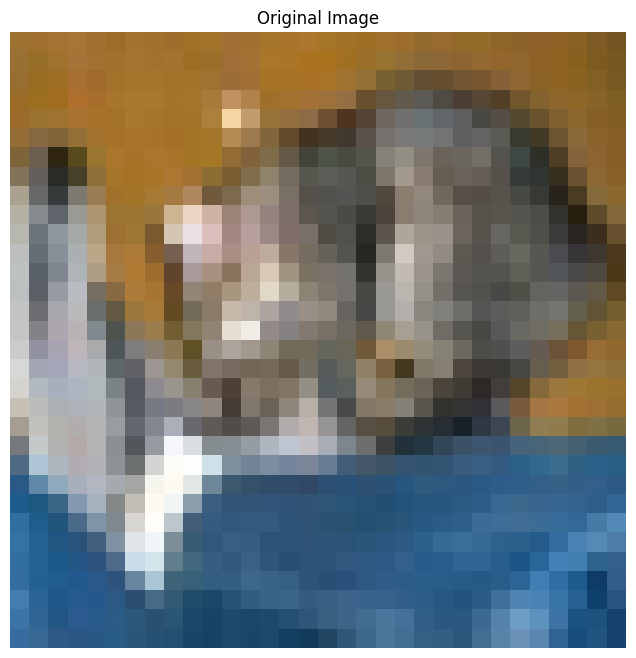

<Figure size 640x480 with 0 Axes>

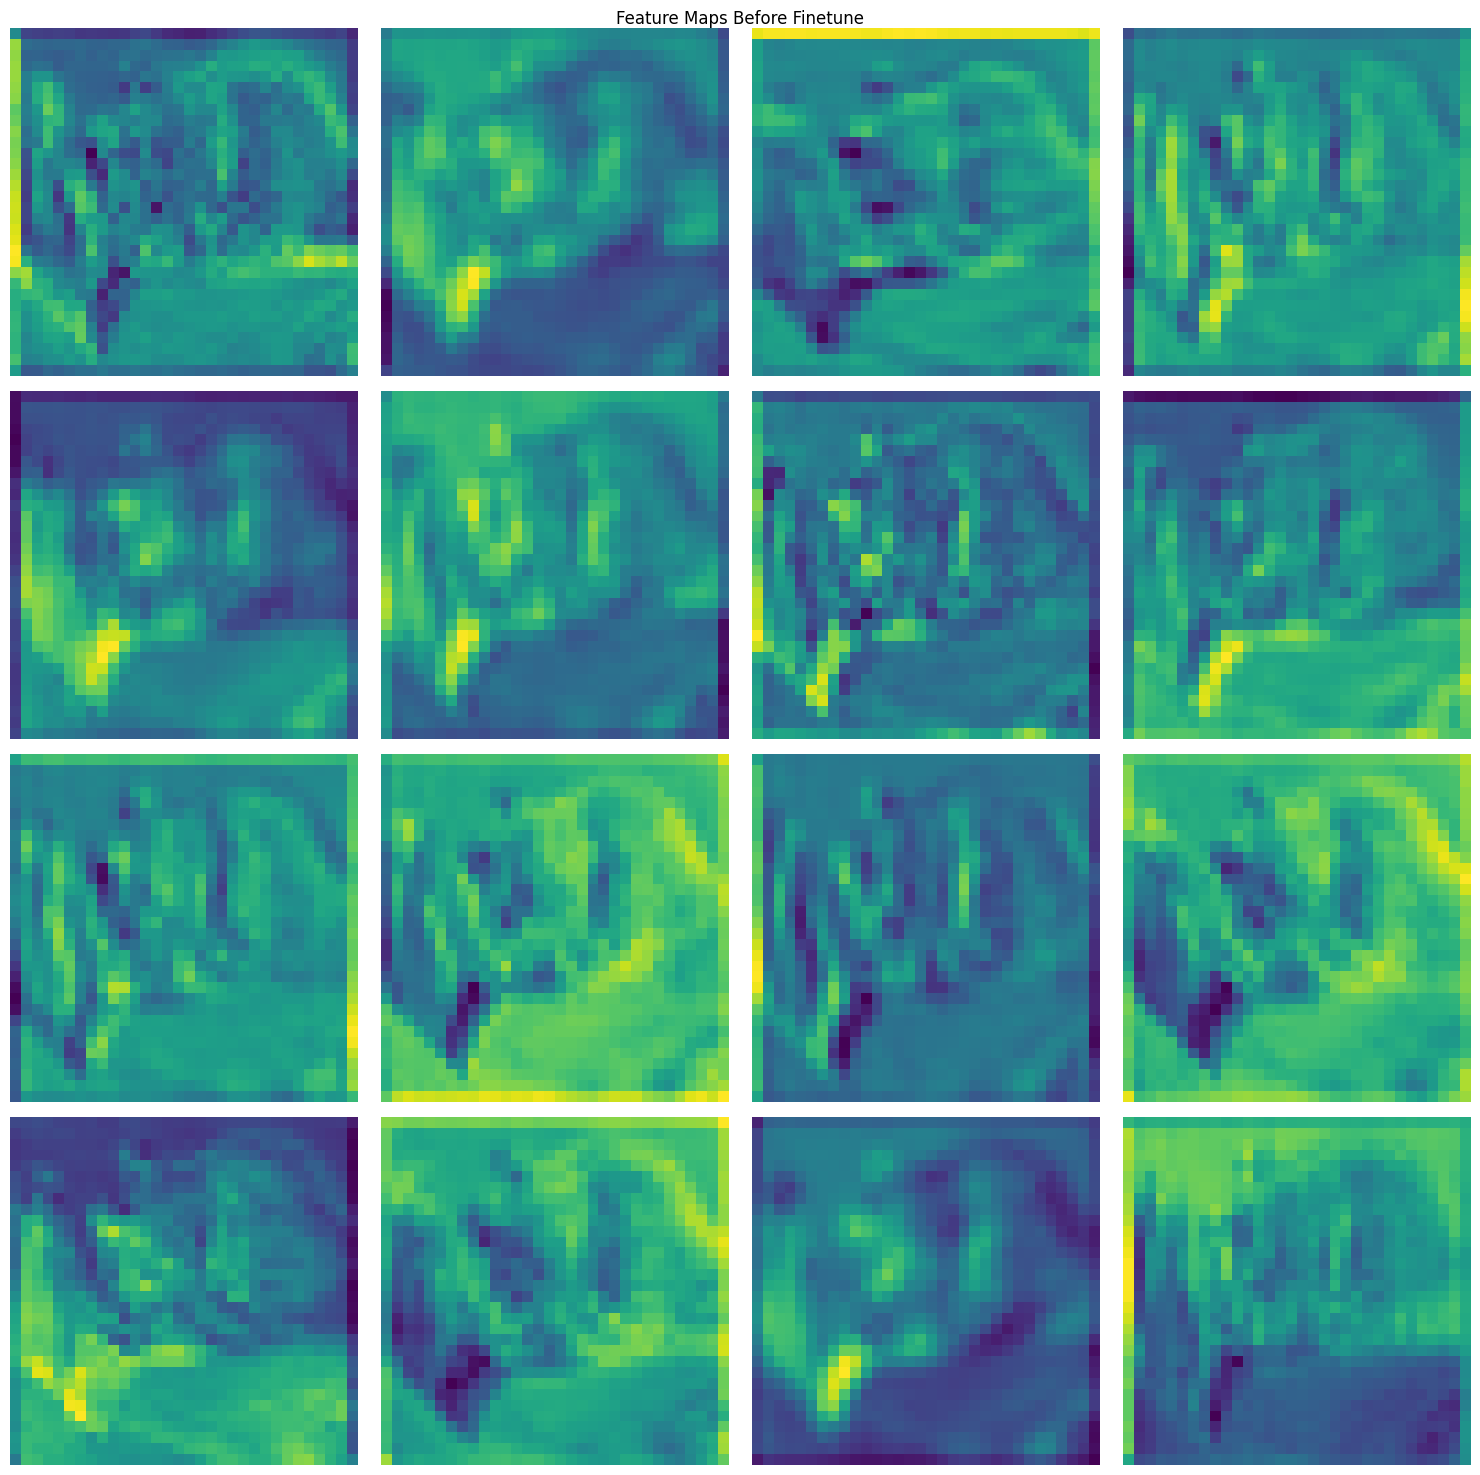

<Figure size 640x480 with 0 Axes>

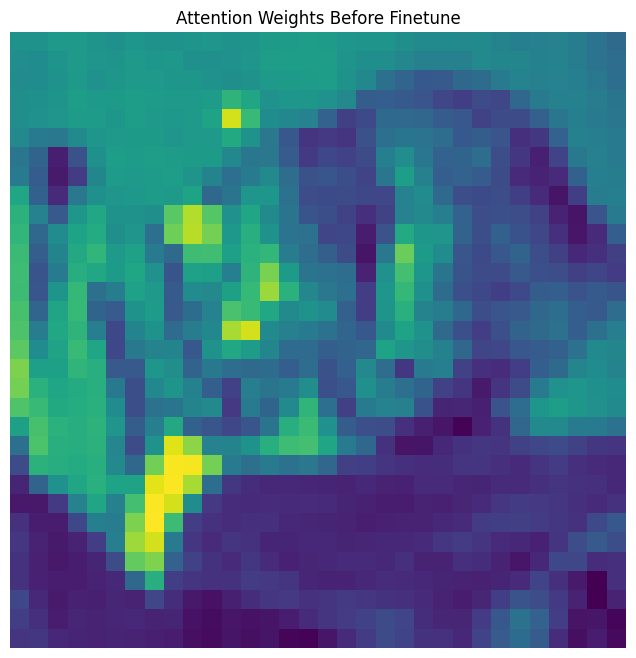

<Figure size 640x480 with 0 Axes>

In [52]:
images, _ = next(iter(test_loader))
sample = images[0]

model = SingleLayerModel().to(device)
model.eval()
with torch.no_grad():
    output, attention_weights, conv_output = model(sample.unsqueeze(0).to(device))

# Visualizations
visualize_image(sample, "Original Image", root="./images/sample_image.png")
visualize_feature_maps(conv_output, "Feature Maps Before Finetune", root="./images/conv_feature_noft.png")
visualize_attention_map(attention_weights, "Attention Weights Before Finetune", root="./images/attn_maps_noft.png")

# **Finetuning**

In [29]:
def train_step(model, dataloader, criterion, optimizer, device, name):
    '''Train for one epoch'''
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(dataloader):
        if name == 'PACS':
            X = data['images']
            y = torch.squeeze(data['labels'])

            X = X.to(device)
            y = y.to(device)

        else:
            X, y = data[0].to(device), data[1].to(device)
        
        logits, attn_weights, feature_maps = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(logits.detach(), dim=1)
        train_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rTraining: [{i+1}/{len(dataloader)}] '
              f'Loss: {train_loss / (i + 1):.4f} '
              f'Acc: {train_acc / (i + 1):.4f}', end='')

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return train_loss, train_acc

@torch.inference_mode()
def eval_step(model, dataloader, criterion, device, name):
    '''Evaluate the model'''
    
    model.eval()

    eval_loss = 0.0
    eval_acc = 0.0

    for i, data in enumerate(dataloader):
        
        if name in ['PACS']:
            X = data['images']
            y = torch.squeeze(data['labels'])

            X = X.to(device)
            y = y.to(device)

        else:
            X, y = data[0].to(device), data[1].to(device)
        
        logits, attn_weights, feature_maps = model(X)
        loss = criterion(logits, y)
        eval_loss += loss.item()

        y_pred = torch.argmax(logits.detach(), dim=1)
        eval_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rEvaluation: [{i+1}/{len(dataloader)}] '
              f'Loss: {eval_loss / (i + 1):.4f} '
              f'Acc: {eval_acc / (i + 1):.4f}', end='')

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return eval_loss, eval_acc

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [31]:
import torch.optim as optim
import csv
from tqdm import tqdm 
import time as time

torch.manual_seed(42)

out_dir = './ft-output'
os.makedirs(out_dir, exist_ok=True)

epochs = 10
lr = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

bar_format = '{l_bar}{bar} | Epoch: {n_fmt}/{total_fmt} | Time: {elapsed} < {remaining} | {rate_fmt}'

params = count_trainable_params(model)
print(f'Finetuning {params*1e-6:.3f}M params on {device} for {epochs} epochs ...\n')

csv_file = os.path.join(out_dir, 'log.csv')
model_file = os.path.join(out_dir, 'weights.pth')

with open(csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

    for epoch in tqdm(range(epochs), desc="Epochs", bar_format=bar_format, leave=True):
        start_time = time.time()  

        train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device, 'custom')
        val_loss, val_acc = eval_step(model, test_loader, criterion, device, 'custom')
        
        writer.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc])
        
        epoch_duration = time.time() - start_time

        tqdm.write(f"============ Epoch {epoch + 1} --> Train Acc: {train_acc:.4f} || Val Acc: {val_acc:.4f} || Time: {epoch_duration:.2f} s ============\n")
    
    torch.save(model.state_dict(), model_file)

Finetuning 1.051M params on cuda for 10 epochs ...



Epochs:   0%|           | Epoch: 0/10 | Time: 00:00 < ? | ?it/s

Training: [1563/1563] Loss: 1.8211 Acc: 0.3641
Evaluation: [308/313] Loss: 1.6033 Acc: 0.4420

Epochs:  10%|█          | Epoch: 1/10 | Time: 00:28 < 04:17 | 28.57s/it

Evaluation: [313/313] Loss: 1.6031 Acc: 0.4414
============ Epoch 1 --> Train Acc: 0.3641 || Val Acc: 0.4414 || Time: 28.57 s ============

Training: [1563/1563] Loss: 1.5113 Acc: 0.4698
Evaluation: [310/313] Loss: 1.4419 Acc: 0.4876

Epochs:  20%|██         | Epoch: 2/10 | Time: 00:56 < 03:47 | 28.45s/it

Evaluation: [313/313] Loss: 1.4418 Acc: 0.4869
============ Epoch 2 --> Train Acc: 0.4698 || Val Acc: 0.4869 || Time: 28.35 s ============

Training: [1563/1563] Loss: 1.3884 Acc: 0.5110
Evaluation: [297/313] Loss: 1.3476 Acc: 0.5250

Epochs:  30%|███        | Epoch: 3/10 | Time: 01:25 < 03:18 | 28.32s/it

Evaluation: [313/313] Loss: 1.3479 Acc: 0.5229
============ Epoch 3 --> Train Acc: 0.5110 || Val Acc: 0.5229 || Time: 28.18 s ============

Training: [1563/1563] Loss: 1.3131 Acc: 0.5398
Evaluation: [289/313] Loss: 1.2984 Acc: 0.5377

Epochs:  40%|████       | Epoch: 4/10 | Time: 01:53 < 02:49 | 28.22s/it

Evaluation: [313/313] Loss: 1.3006 Acc: 0.5351
============ Epoch 4 --> Train Acc: 0.5398 || Val Acc: 0.5351 || Time: 28.06 s ============

Training: [1563/1563] Loss: 1.2574 Acc: 0.5595
Evaluation: [310/313] Loss: 1.2647 Acc: 0.5546

Epochs:  50%|█████      | Epoch: 5/10 | Time: 02:21 < 02:20 | 28.15s/it

Evaluation: [313/313] Loss: 1.2652 Acc: 0.5539
============ Epoch 5 --> Train Acc: 0.5595 || Val Acc: 0.5539 || Time: 28.01 s ============

Training: [1563/1563] Loss: 1.2147 Acc: 0.5760
Evaluation: [302/313] Loss: 1.2317 Acc: 0.5654

Epochs:  60%|██████     | Epoch: 6/10 | Time: 02:49 < 01:52 | 28.14s/it

Evaluation: [313/313] Loss: 1.2339 Acc: 0.5642
============ Epoch 6 --> Train Acc: 0.5760 || Val Acc: 0.5642 || Time: 28.12 s ============

Training: [1563/1563] Loss: 1.1779 Acc: 0.5876
Evaluation: [295/313] Loss: 1.1980 Acc: 0.5783

Epochs:  70%|███████    | Epoch: 7/10 | Time: 03:17 < 01:24 | 28.12s/it

Evaluation: [313/313] Loss: 1.2001 Acc: 0.5774
============ Epoch 7 --> Train Acc: 0.5876 || Val Acc: 0.5774 || Time: 28.07 s ============

Training: [1563/1563] Loss: 1.1452 Acc: 0.6006
Evaluation: [291/313] Loss: 1.1888 Acc: 0.5815

Epochs:  80%|████████   | Epoch: 8/10 | Time: 03:45 < 00:56 | 28.10s/it

Evaluation: [313/313] Loss: 1.1894 Acc: 0.5805
============ Epoch 8 --> Train Acc: 0.6006 || Val Acc: 0.5805 || Time: 28.07 s ============

Training: [1563/1563] Loss: 1.1143 Acc: 0.6110
Evaluation: [311/313] Loss: 1.1602 Acc: 0.5967

Epochs:  90%|█████████  | Epoch: 9/10 | Time: 04:13 < 00:28 | 28.09s/it

Evaluation: [313/313] Loss: 1.1596 Acc: 0.5962
============ Epoch 9 --> Train Acc: 0.6110 || Val Acc: 0.5962 || Time: 28.06 s ============

Training: [1563/1563] Loss: 1.0878 Acc: 0.6210
Evaluation: [306/313] Loss: 1.1433 Acc: 0.6072

Epochs: 100%|██████████ | Epoch: 10/10 | Time: 04:41 < 00:00 | 28.16s/it

Evaluation: [313/313] Loss: 1.1447 Acc: 0.6048
============ Epoch 10 --> Train Acc: 0.6210 || Val Acc: 0.6048 || Time: 28.08 s ============



# **Feature Maps: After Finetuning**

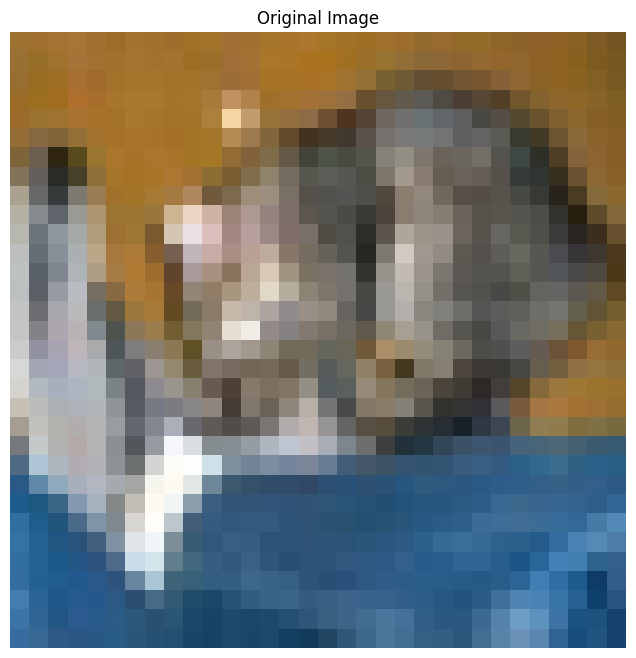

<Figure size 640x480 with 0 Axes>

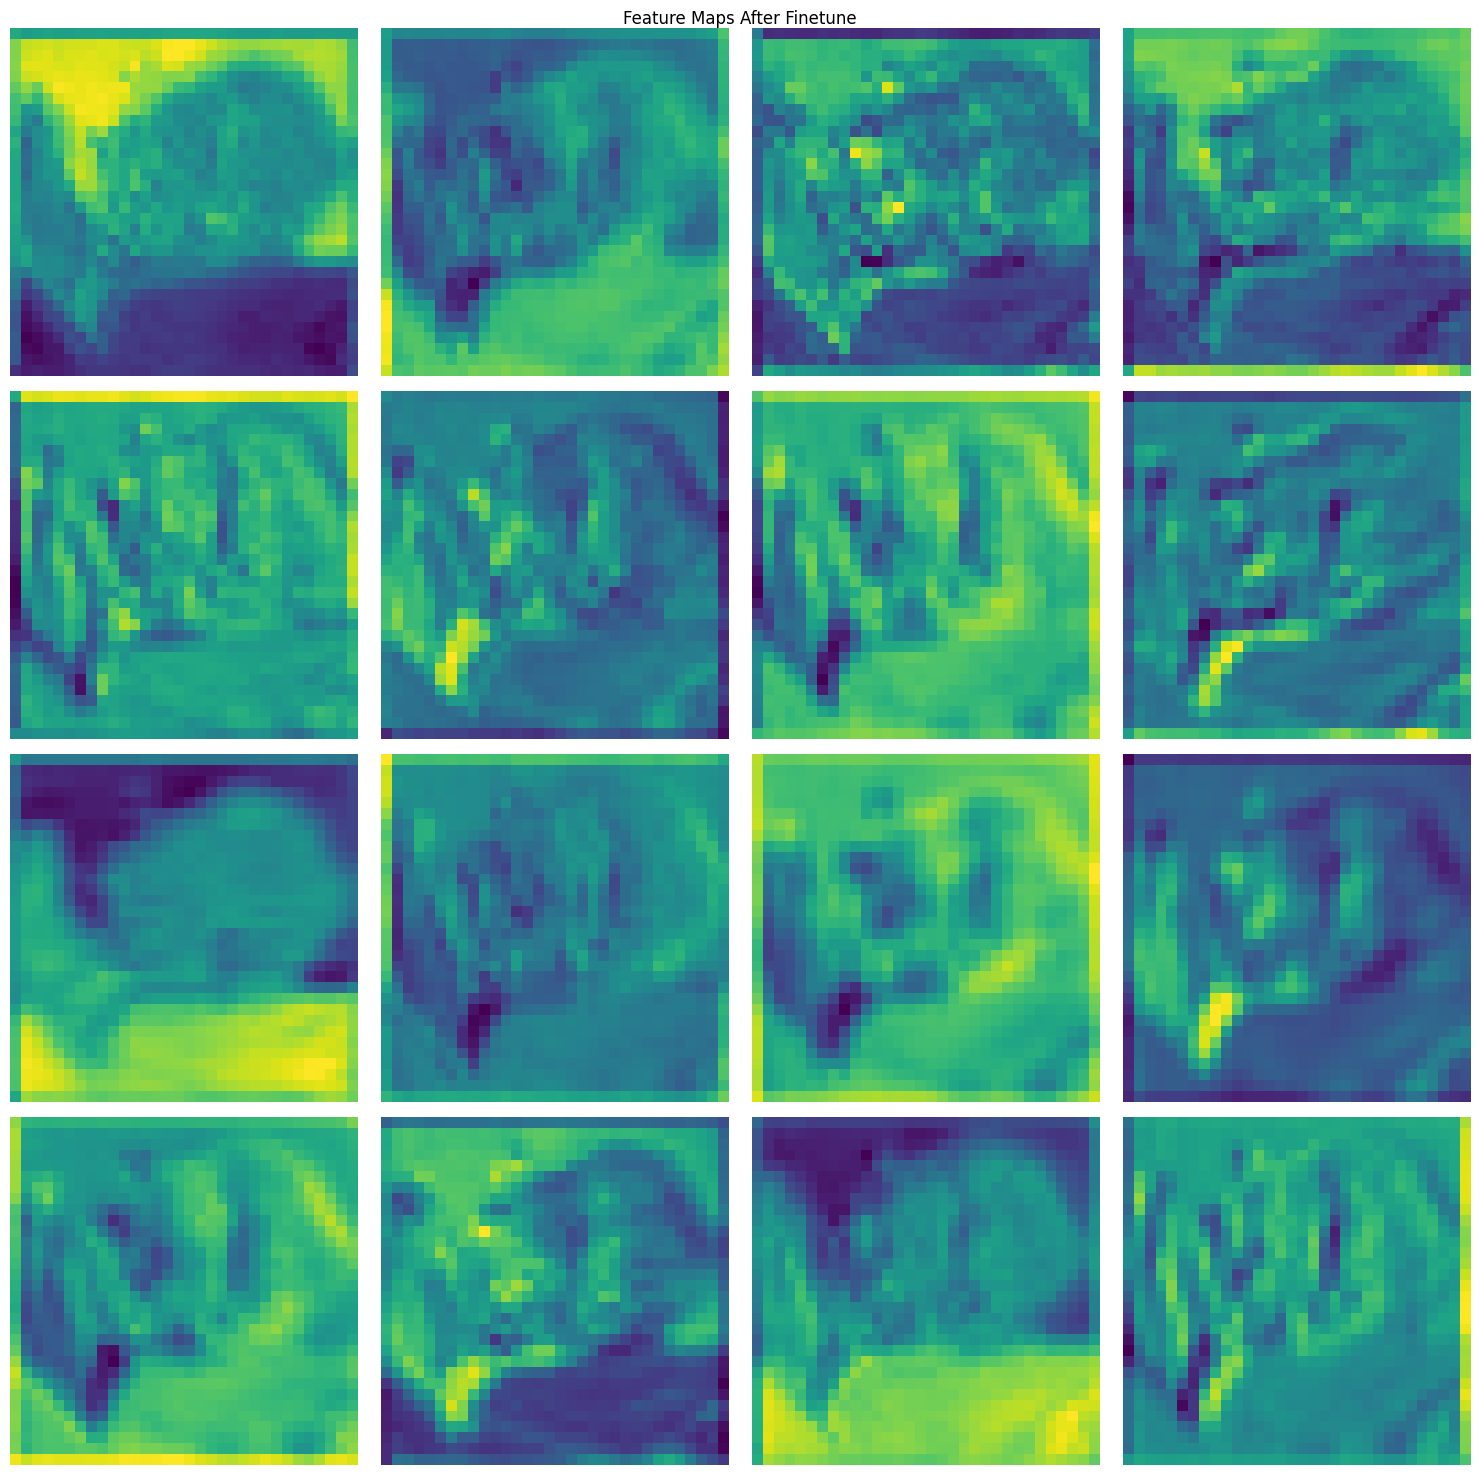

<Figure size 640x480 with 0 Axes>

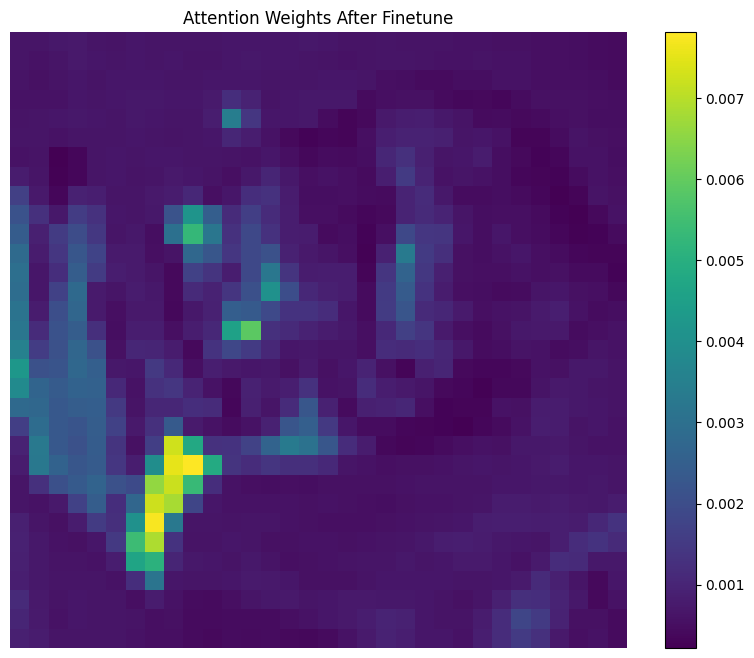

<Figure size 640x480 with 0 Axes>

In [32]:
images, _ = next(iter(test_loader))
sample = images[0]

model.eval()
with torch.no_grad():
    output, attention_weights, conv_output = model(sample.unsqueeze(0).to(device))

# Visualizations
visualize_image(sample, "Original Image", root="./images/sample_image.png")
visualize_feature_maps(conv_output, "Feature Maps After Finetune", root="./images/conv_feature_ft.png")
visualize_attention_map(attention_weights, "Attention Weights After Finetune", root="./images/attn_maps_ft.png")

In [33]:
import shutil
shutil.make_archive("ft-output", 'zip', "/kaggle/working/ft-output")
shutil.make_archive("task6-5-images", 'zip', "/kaggle/working/images")

'/kaggle/working/task6-5-images.zip'